In [1]:
import time
import sys
import numpy as np
import scvelo as scv
import scanpy
import scipy
import anndata
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

from veloproj import *
from torch import optim
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--data-dir', '/data/groups/yhhuang/scNT/neuron_splicing_lite.h5ad',
                               '--exp-name', 'baseline_scNT',
                               '--device', 'cuda:3'
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("0", "15"), ("15", "30"), ("30", "60"), ("60", "120")]
k_cluster = "time"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    i, losses = 0, [sys.maxsize]
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_u, tensor_s, tensor_x], model, optimizer)                
        losses.append(loss)
        if i % args.log_interval == 0:
            plt.plot(losses[1:])
            display.clear_output(wait=True)
            plt.show()
            print("Train Epoch: {:2d} Loss: {:.6f}"
                  .format(i, losses[-1]))
            
            if abs(np.mean(losses[-11:]) - losses[-1]) < args.conv_thred:
                print("Seems converging, stop training.")
                break
    
    plt.plot(losses[1:])
    display.clear_output(wait=True)
    plt.show()
    print(losses[-1])
    return model

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
adata.obs['time'] = adata.obs.time.astype('category')
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]
Filtered out 39141 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3066 × 2000
    obs: 'cellname', 'time', 'early', 'late', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_short_name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


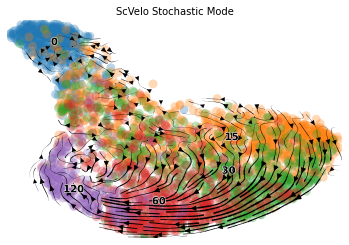

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.18047157, ('15', '30'): 0.18490802, ('30', '60'): 0.23314989, ('60', '120'): 0.26255786}
Total Mean: 0.21527183055877686
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.882237, ('15', '30'): 0.84970397, ('30', '60'): 0.8860251, ('60', '120'): 0.94955367}
Total Mean: 0.8918799757957458
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.1873846970844583, ('15', '30'): 0.18306115502453824, ('30', '60'): 0.2604929039751113, ('60', '120'): 0.37984779735682245}
Total Mean: 0.25269663836023254
# In-cluster Coherence
{'0': 0.9150234, '120': 0.96112585, '15': 0.86938363, '30': 0.8747749, '60': 0.9513406}
Total Mean: 0.9143296480178833
# In-cluster Confidence
{'0': 0.5655337789948088, '120': 0.5211500842643686, '15': 0.5152785540017158, '30': 0.5523610212043529, '60': 0.6307097600359652}
Total Mean: 0.5570066397002422


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['time'],
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

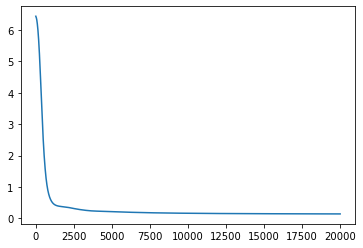

0.143581822514534
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


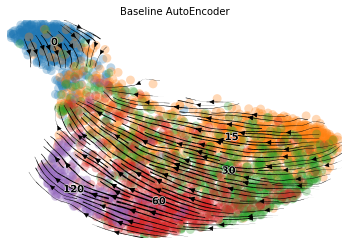

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.06473316, ('15', '30'): 0.05953183, ('30', '60'): 0.057702873, ('60', '120'): 0.11700469}
Total Mean: 0.07474313676357269
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.94679576, ('15', '30'): 0.9301643, ('30', '60'): 0.9530374, ('60', '120'): 0.98190385}
Total Mean: 0.952975332736969
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.6086923204979175, ('15', '30'): 0.02783302671911441, ('30', '60'): 0.19227679406858628, ('60', '120'): 0.4284121407894661}
Total Mean: 0.31430357051877106
# In-cluster Coherence
{'0': 0.9659324, '120': 0.9881581, '15': 0.93617195, '30': 0.9435209, '60': 0.9855373}
Total Mean: 0.9638641476631165
# In-cluster Confidence
{'0': 0.937266572976539, '120': 0.977587250836817, '15': 0.9060177358267195, '30': 0.9096728229794201, '60': 0.9

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim #100
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model)
    
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['time'],
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

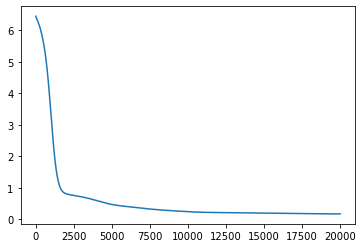

0.17625859379768372
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


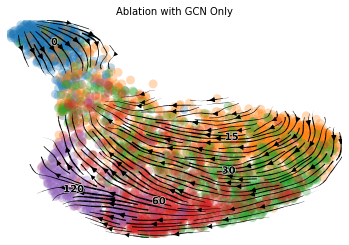

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.08672906, ('15', '30'): 0.07496008, ('30', '60'): 0.057440445, ('60', '120'): 0.087863445}
Total Mean: 0.07674825191497803
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.93005484, ('15', '30'): 0.9037124, ('30', '60'): 0.93878615, ('60', '120'): 0.9792231}
Total Mean: 0.9379441142082214
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.7214857672929684, ('15', '30'): 0.2511158562038757, ('30', '60'): 0.24672839186734563, ('60', '120'): 0.40280045077230997}
Total Mean: 0.4055326165341249
# In-cluster Coherence
{'0': 0.9576195, '120': 0.98931766, '15': 0.9119594, '30': 0.92328495, '60': 0.98466134}
Total Mean: 0.9533685445785522
# In-cluster Confidence
{'0': 0.9471885601696152, '120': 0.98697641575004, '15': 0.9145982012064903, '30': 0.9187854015331856, '60': 

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    conn = adata.obsp['connectivities']
    nb_indices = adata.uns['neighbors']['indices']
    xs, ys = np.repeat(range(n_cells), nb_indices.shape[1]-1), nb_indices[:, 1:].flatten()
    edge_weight = torch.FloatTensor(conn[xs,ys]).view(-1).to(device)
    edge_index = torch.LongTensor(np.vstack([xs.reshape(1,-1), xs.reshape(1, -1)])).to(device)
    
    model = get_ablation_CohAgg(edge_index,
                                  edge_weight,
                                  in_dim,
                                  z_dim,
                                  h_dim,
                                  device)
    model = main_AE(args, model, lr=5e-6)
    
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['time'],
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

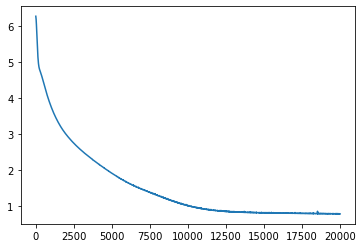

0.7816178798675537
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


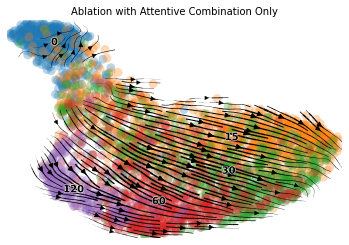

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.47085476, ('15', '30'): 0.43265992, ('30', '60'): 0.358275, ('60', '120'): 0.29757732}
Total Mean: 0.3898417353630066
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.95609224, ('15', '30'): 0.93870384, ('30', '60'): 0.9529575, ('60', '120'): 0.98335207}
Total Mean: 0.9577764272689819
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): -0.04843593916242964, ('15', '30'): 0.1756008496559349, ('30', '60'): -0.06896504073758407, ('60', '120'): -0.44145430139312686}
Total Mean: -0.09581360790930142
# In-cluster Coherence
{'0': 0.96971416, '120': 0.9863239, '15': 0.944415, '30': 0.94636226, '60': 0.98262584}
Total Mean: 0.9658882021903992
# In-cluster Confidence
{'0': 0.9651240331247882, '120': 0.9848834703643009, '15': 0.944176815145927, '30': 0.9421436644271949, '60'

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        device)
    model = main_AE(args, model, lr=1e-6)
    
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s

    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['time'],
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


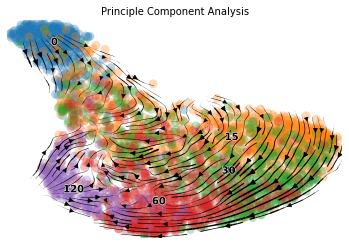

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.0125834895, ('15', '30'): 0.017009664, ('30', '60'): 0.019886032, ('60', '120'): 0.013020424}
Total Mean: 0.01562490314245224
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.9171571, ('15', '30'): 0.881781, ('30', '60'): 0.9266355, ('60', '120'): 0.97474134}
Total Mean: 0.9250787496566772
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.32880040410927375, ('15', '30'): 0.3372733490390259, ('30', '60'): 0.3025778453919149, ('60', '120'): 0.1345571324881039}
Total Mean: 0.27580218275707963
# In-cluster Coherence
{'0': 0.9489812, '120': 0.9850335, '15': 0.89790756, '30': 0.90694386, '60': 0.9774094}
Total Mean: 0.9432551264762878
# In-cluster Confidence
{'0': 0.9368370819536832, '120': 0.9817775426157918, '15': 0.8991207535861362, '30': 0.9005042239505492, '60'

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
   
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['time'],
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


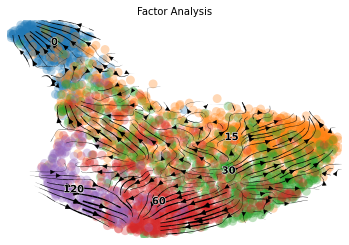

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.08561435, ('15', '30'): 0.09878913, ('30', '60'): 0.12114497, ('60', '120'): 0.08544829}
Total Mean: 0.09774918854236603
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.8088766433878994, ('15', '30'): 0.7799696236670703, ('30', '60'): 0.775552215471132, ('60', '120'): 0.7967651324379501}
Total Mean: 0.790290903741013
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): -0.4224752947523021, ('15', '30'): -0.1403994826860767, ('30', '60'): -0.11079354637339585, ('60', '120'): 0.21516834186028574}
Total Mean: -0.11462499548787222
# In-cluster Coherence
{'0': 0.8502764291901936, '120': 0.8431370448676831, '15': 0.8089188561879155, '30': 0.8029726787451354, '60': 0.8392092125079933}
Total Mean: 0.8289028442997843
# In-cluster Confidence
{'0': 0.8296507173919487, '120':

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['time'],
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [17]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)